# R8

In [ ]:
# Add pvals, convert to 4 groups of nested bar plots

In [1]:
# ../results/2024-03-26 <- removed Tybalt
production_date = '2024-03-26' 

In [2]:
%whos

Variable          Type    Data/Info
-----------------------------------
production_date   str     2024-03-26


In [4]:
# Data handling & comparision setup
import pandas as pd
import glob
import itertools

# Feature selection, RFE
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

# Import 3 SciKit Learn classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression

# SVM
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Classification setup and eval
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import statistics

# Plotting
import matplotlib.pyplot as plt

### Set data paths

#### Input read

In [5]:
# phase = 'Input', need for all comparisons
inp_pths = sorted(
    glob.glob('../data/r72/nc*.tsv'), reverse = True)
inp_pths

['../data/r72/nc5_transcriptomics_cell-line+CPTAC.input-data.tsv',
 '../data/r72/nc2_transcriptomics_HCMI+CPTAC.input-data.tsv']

#### MBatch

In [ ]:
# phase = 'MBatch'
mb_pths = sorted(
    glob.glob('../results/r72/mbatch/*.tsv'), reverse = True)
mb_pths

#### Qaunt rescale

In [ ]:
qs_pths = sorted(
    glob.glob('../results/r72/quant-resc/*.tsv'), reverse = True)
qs_pths

#### Tybalt

In [ ]:
tb_pths = sorted(
    glob.glob('../results/r72/tybalt/*.tsv'), reverse = True)
tb_pths

### Load data

In [ ]:
path_index_toggle = 0
cancer_count = 5
sys_togg = 'cell-line'
sys_file_names = 'cell-line+CPTAC'
sample_count_lbl = 'Cell line'
mdl_sys_inline = 'cell line'

In [ ]:
path_index_toggle = 1
cancer_count = 2
sys_togg = 'hcmi'
sys_file_names = 'HMCI+CPTAC'
sample_count_lbl = 'HCMI'
mdl_sys_inline = 'HCMI'

##### Continue

In [ ]:
path_index_toggle

In [ ]:
inp_pths

In [ ]:
# Input load
input_df = pd.read_csv(
                inp_pths[path_index_toggle], # nc5 or nc2 file
                sep = '\t',
                index_col = 0)
print('inpt len:', len(input_df))

In [ ]:
input_df

In [ ]:
input_df.isna().sum().sum()

In [ ]:
corr_pths = mb, qs_pths
corr_mthd_title = 'MBatch'
mthd_file_disk_name = 'mbatch'
latent_dim = 'NA'

In [ ]:
# MBatch load
mbatch_df = pd.read_csv(
                mb_pths[path_index_toggle],
                sep = '\t',
                index_col = 0)

print('MB corr len:', len(mbatch_df))

In [ ]:
# Quant-resc load
quant_resc_df = pd.read_csv(
                qs_pths[path_index_toggle],
                sep = '\t',
                index_col = 0)

print('QS corr len:', len(quant_resc_df))

In [ ]:
quant_resc_df.isna().sum().sum()

In [ ]:
quant_resc_df = quant_resc_df.loc[:, quant_resc_df.isna().any(axis=0) == False]

In [ ]:
# Tybalt load
tybalt_df = pd.read_csv(
            tb_pths[path_index_toggle],
            sep = '\t',
            index_col = 0)
print('Tybalt latent len:', len(tybalt_df))
latent_dim = tybalt_df.shape[1] - 2
latent_dim

In [ ]:
sys_togg

In [ ]:
path_index_toggle

### Clf

In [ ]:
# print('Begin clf on ', phase)
print('Begin sub-sampled, matched-cross val\n classification evals')
print(' ')
print('Input file:\n', inp_pths[path_index_toggle].split('/')[-1])
# print('Correction file:\n', corr_pths[path_index_toggle].split('/')[-1])
print(' ')

clf_list = [RandomForestClassifier(max_depth=2, random_state=0),
            tree.DecisionTreeClassifier(),
            LogisticRegression(random_state=0, max_iter=5000),
            make_pipeline(StandardScaler(),
                LinearSVC(dual="auto", random_state=0,
                          max_iter=100000, tol=1e-5))]

print('path_index_toggle', path_index_toggle)
print('sys_togg', sys_togg)

# if path_index_toggle == 1:
# # HCMI
# # Subset training input
#     inp_mdl_sys_train_df = input_df[input_df.System == sys_togg]

# # Subset correction object, toggle with file read
#     corr_mdl_sys_train_df = corr_df[corr_df.System == sys_togg]
# else:
#     print('cell-line')
#     print(sys_togg)
#     inp_mdl_sys_train_df = input_df[input_df.System == sys_togg]
#     corr_mdl_sys_train_df = corr_df[corr_df.System == sys_togg]

# Subset training input
inp_mdl_sys_train_df = input_df[input_df.System == sys_togg]

# Subset correction objects
mbatch_mdl_sys_train_df = mbatch_df[mbatch_df.System == sys_togg]
quant_resc_mdl_sys_train_df = quant_resc_df[quant_resc_df.System == sys_togg]
tybalt_mdl_sys_train_df = tybalt_df[tybalt_df.System == sys_togg]

# List of dicts
results = []

for cross_val in range(30): # chk
    print('cross_val', cross_val)

    # Train set sub-sample, input - X and y
    X_input = inp_mdl_sys_train_df.iloc[:, 2:]
    X_input = X_input.sample(round(len(X_input)*.85))
    y_input = inp_mdl_sys_train_df[inp_mdl_sys_train_df.index.isin(
                                        X_input.index)].Cancer_type

    # Train set sub-sample, mbatch - X and y
    X_mbatch = mbatch_mdl_sys_train_df.iloc[:, 2:]
    X_mbatch = X_mbatch[X_mbatch.index.isin(X_input.index)]
    y_mbatch = mbatch_mdl_sys_train_df[mbatch_mdl_sys_train_df.index.isin(
                                        X_mbatch.index)].Cancer_type

    # Train set sub-sample, quant-resc - X and y
    X_quant_resc = quant_resc_mdl_sys_train_df.iloc[:, 2:]
    X_quant_resc = X_quant_resc[X_quant_resc.index.isin(X_input.index)]
    y_quant_resc = quant_resc_mdl_sys_train_df[quant_resc_mdl_sys_train_df.index.isin(
                                        X_quant_resc.index)].Cancer_type

    # Train set sub-sample, Tybalt - X and y
    X_tybalt = tybalt_mdl_sys_train_df.iloc[:, 2:]
    X_tybalt = X_tybalt[X_tybalt.index.isin(X_input.index)]
    y_tybalt = tybalt_mdl_sys_train_df[tybalt_mdl_sys_train_df.index.isin(
                                        X_tybalt.index)].Cancer_type

    # Test set extraction, input and corr
    CPTAC_input = input_df[input_df.System == 'cptac']
    CPTAC_mbatch  = mbatch_df[mbatch_df.System == 'cptac']
    CPTAC_quant_resc = quant_resc_df[quant_resc_df.System == 'cptac']
    CPTAC_tybalt =tybalt_df[tybalt_df.System == 'cptac']

    # print(len(CPTAC_input))
    # print(len(CPTAC_corr))
    
    clf_i_list = ['RF', 'DT', 'LR', 'SVM']

    # Classifier loop, input
    print('Start input loop')
    input_score_list = []
    for clf_i in range(len(clf_list)):
        clf = clf_list[clf_i]
        clf.fit(X_input,
                y_input)
    
        score = f1_score(CPTAC_input.Cancer_type,
                         clf.predict(CPTAC_input.iloc[:, 2:]),
                         average = 'weighted')
        
        results.append({
            'cross_val': cross_val,
            'classifier': clf_i_list[clf_i],
            'score': score,
            'type': 'Input'
        })
        # break
    # Classifier loop, MBatch
    print('Start MBatch eval loop')
    for clf_i in range(len(clf_list)):
        clf = clf_list[clf_i]
        clf.fit(X_mbatch,
                y_mbatch)
    
        score = f1_score(CPTAC_mbatch.Cancer_type,
                         clf.predict(CPTAC_mbatch.iloc[:, 2:]),
                         average = 'weighted')
        results.append({
            'cross_val': cross_val,
            'classifier': clf_i_list[clf_i],
            'score': score,
            'type': 'MBatch'
        })

    # Classifier loop, Quant rescale
    print('Start quant rescale eval loop')
    for clf_i in range(len(clf_list)):
        clf = clf_list[clf_i]
        clf.fit(X_quant_resc,
                y_quant_resc)
    
        score = f1_score(CPTAC_quant_resc.Cancer_type,
                         clf.predict(CPTAC_quant_resc.iloc[:, 2:]),
                         average = 'weighted')
        results.append({
            'cross_val': cross_val,
            'classifier': clf_i_list[clf_i],
            'score': score,
            'type': 'Quant-resc'
        })

    # Classifier loop, Tybalt
    print('Start Tybalt eval loop')
    for clf_i in range(len(clf_list)):
        clf = clf_list[clf_i]
        clf.fit(X_tybalt,
                y_tybalt)
    
        score = f1_score(CPTAC_tybalt.Cancer_type,
                         clf.predict(CPTAC_tybalt.iloc[:, 2:]),
                         average = 'weighted')
        results.append({
            'cross_val': cross_val,
            'classifier': clf_i_list[clf_i],
            'score': score,
            'type': 'Tybalt'
        })

    # print('end cross fold')
    print(' ')
    # break
print('done')

In [ ]:
results_df = pd.DataFrame(results)

In [ ]:
len(results_df)

In [ ]:
pd.options.display.max_rows = 500

In [ ]:
results_df

In [ ]:
print(sys_file_names)
print(mthd_file_disk_name)

In [ ]:
ls ../results/r72/

In [ ]:
ls ../results/r8/

In [ ]:
inp_pths[path_index_toggle]

In [ ]:
inp_pths[path_index_toggle].split('/')[-1].split('.')[0]

In [ ]:
results_df.to_csv('../results/r8/'+
                  production_date+
                  '/input+multi-corr-methods_clf-eval-n4_x-val=30_'+
                  inp_pths[path_index_toggle].split('/')[-1].split('.')[0]+
                  '.tsv',
                 sep = '\t')

In [ ]:
results_df

In [ ]:
results_df['type'] = results_df['type'].replace('Tybalt', 'Tybalt VAE')

In [ ]:
sample_count_lbl

### v2

In [ ]:
# ^ read this results df for input, mbatch, and quant rescale
# find the 4x6 frame for the 4 vaes <- no, this was a joint embedding

In [12]:
ls ../results/r72/2024-03-19/input-vae*cell-line+CPTAC.tsv

../results/r72/2024-03-19/input-vae_beta-classifier_clf-eval-n4_x-val=30_cell-line+CPTAC.tsv
../results/r72/2024-03-19/input-vae_classifier_clf-eval-n4_x-val=30_cell-line+CPTAC.tsv
../results/r72/2024-03-19/input-vae_cntrstv-loss_clf-eval-n4_x-val=30_cell-line+CPTAC.tsv
../results/r72/2024-03-19/input-vae_disc_clf-eval-n4_x-val=30_cell-line+CPTAC.tsv


In [13]:
vae_trans = sorted(glob.glob('../results/r72/2024-03-19/input-vae*cell-line+CPTAC.tsv'))

In [14]:
vae_trans

['../results/r72/2024-03-19/input-vae_beta-classifier_clf-eval-n4_x-val=30_cell-line+CPTAC.tsv',
 '../results/r72/2024-03-19/input-vae_classifier_clf-eval-n4_x-val=30_cell-line+CPTAC.tsv',
 '../results/r72/2024-03-19/input-vae_cntrstv-loss_clf-eval-n4_x-val=30_cell-line+CPTAC.tsv',
 '../results/r72/2024-03-19/input-vae_disc_clf-eval-n4_x-val=30_cell-line+CPTAC.tsv']

In [58]:
corr_list = ['vae_beta', 'vae_clssfr', 'vae_cntrstv', 'vae_disc']
vaes_4 = pd.DataFrame()
for i, fpth in enumerate(vae_trans):
    print(fpth)
    df = pd.read_csv(fpth, sep = '\t', index_col = 0)
    df = df[df.type != 'input']
    df.type = corr_list[i]
    vaes_4 = pd.concat([vaes_4, df])

../results/r72/2024-03-19/input-vae_beta-classifier_clf-eval-n4_x-val=30_cell-line+CPTAC.tsv
../results/r72/2024-03-19/input-vae_classifier_clf-eval-n4_x-val=30_cell-line+CPTAC.tsv
../results/r72/2024-03-19/input-vae_cntrstv-loss_clf-eval-n4_x-val=30_cell-line+CPTAC.tsv
../results/r72/2024-03-19/input-vae_disc_clf-eval-n4_x-val=30_cell-line+CPTAC.tsv


In [59]:
vaes_4

,cross_val,classifier,score,type
4,0,RF,0.113705,vae_beta
5,0,DT,0.198079,vae_beta
6,0,LR,0.205505,vae_beta
7,0,SVM,0.209640,vae_beta
12,1,RF,0.102978,vae_beta
...,...,...,...,...
231,28,SVM,0.229200,vae_disc
236,29,RF,0.070375,vae_disc
237,29,DT,0.133617,vae_disc
238,29,LR,0.203806,vae_disc


In [32]:
ls ../results/r8/2024-03-20/

input+multi-corr-methods_clf-eval-n4_x-val=30_nc5_transcriptomics_cell-line+CPTAC.png
input+multi-corr-methods_clf-eval-n4_x-val=30_nc5_transcriptomics_cell-line+CPTAC.tsv
input-tybalt_clf-eval-n4_x-val=30_nc3a_proteomics_cell-line+CPTAC.png
input-tybalt_clf-eval-n4_x-val=30_nc3a_proteomics_cell-line+CPTAC.tsv
input-tybalt_clf-eval-n4_x-val=30_nc3b_proteomics_cell-line+CPTAC.png
input-tybalt_clf-eval-n4_x-val=30_nc3b_proteomics_cell-line+CPTAC.tsv
input-tybalt_clf-eval-n4_x-val=30_nc3c_proteomics_cell-line+CPTAC.png
input-tybalt_clf-eval-n4_x-val=30_nc3d_proteomics_cell-line+CPTAC.png
input-tybalt_clf-eval-n4_x-val=30_nc3d_proteomics_cell-line+CPTAC.tsv
input-tybalt_clf-eval-n4_x-val=30_nc4_proteomics_cell-line+CPTAC.png
input-tybalt_clf-eval-n4_x-val=30_nc4_proteomics_cell-line+CPTAC.tsv
input-tybalt_clf-eval-n4_x-val=30_nc4_tran-prot_cell-line+CPTAC.png
input-tybalt_clf-eval-n4_x-val=30_nc4_tran-prot_cell-line+CPTAC.tsv


In [33]:
fnm = 'input+multi-corr-methods_clf-eval-n4_x-val=30_nc5_transcriptomics_cell-line+CPTAC.tsv'

In [46]:
inp_lins = pd.read_csv('../results/r8/2024-03-20/'+
                       'input+multi-corr-methods_clf-eval-n4_x-val=30_nc5_transcriptomics_cell-line+CPTAC.tsv',
                      sep = '\t', index_col = 0)

In [47]:
inp_lins

,cross_val,classifier,score,type
0,0,RF,0.070542,Input
1,0,DT,0.053057,Input
2,0,LR,0.140055,Input
3,0,SVM,0.219407,Input
4,0,RF,0.140516,MBatch
...,...,...,...,...
475,29,SVM,0.964580,Quant-resc
476,29,RF,0.371678,Tybalt
477,29,DT,0.700463,Tybalt
478,29,LR,0.423214,Tybalt


In [48]:
inp_lins.isna().sum().sum()

0

In [49]:
inp_lins = inp_lins[inp_lins.type != 'Tybalt']

In [50]:
inp_lins.isna().sum().sum()

0

In [60]:
final = pd.concat([inp_lins, vaes_4])

In [61]:
final

,cross_val,classifier,score,type
0,0,RF,0.070542,Input
1,0,DT,0.053057,Input
2,0,LR,0.140055,Input
3,0,SVM,0.219407,Input
4,0,RF,0.140516,MBatch
...,...,...,...,...
231,28,SVM,0.229200,vae_disc
236,29,RF,0.070375,vae_disc
237,29,DT,0.133617,vae_disc
238,29,LR,0.203806,vae_disc


### Plot

In [ ]:
[i for i in input_df.Cancer_type.unique()]

In [ ]:
input_df.Cancer_type.value_counts()

In [55]:
production_date

'2024-03-26'

In [56]:
inp_pths[path_index_toggle]

NameError: name 'path_index_toggle' is not defined

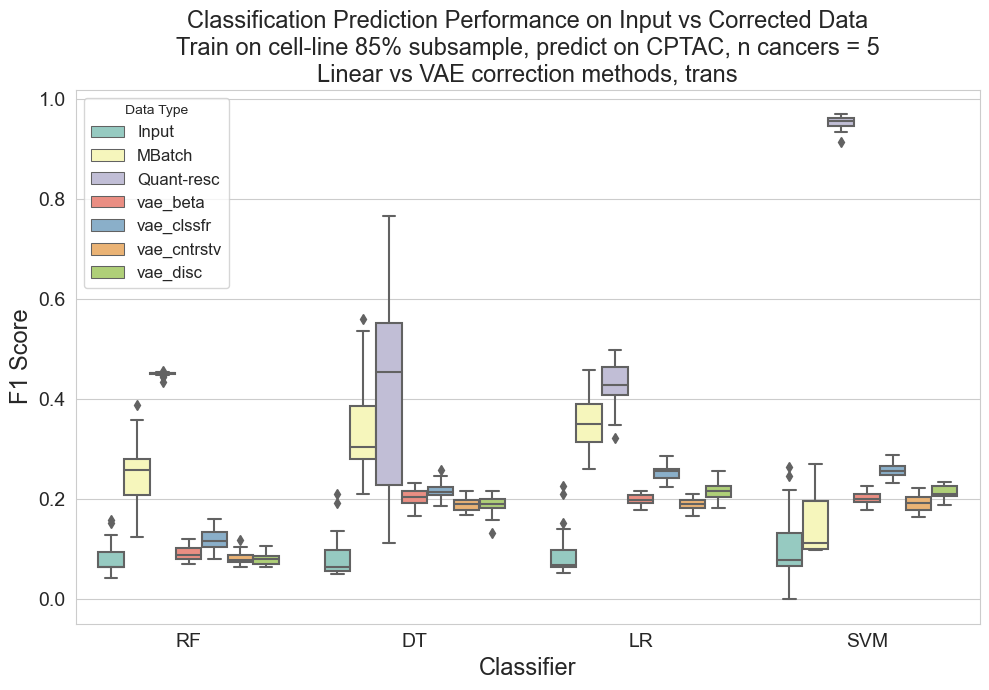

In [63]:
dta_mode = 'trans'

cancer_count = 5

import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a figure and axis
plt.figure(figsize=(10, 7))

# Plot
sns.boxplot(data=final, x='classifier', y='score',
            hue='type', palette='Set3')

# cancer_count = 5
# cancer_count = 5

# Adding title and labels
plt.title('Classification Prediction Performance on Input'+
          ' vs Corrected Data\nTrain on cell-line 85% subsample, '+
          'predict on CPTAC, n cancers = '+str(cancer_count)+
          '\nLinear vs VAE correction methods, '+dta_mode, fontsize=17)
plt.xlabel('Classifier', fontsize=17)
plt.xticks(#rotation=45,
           fontsize=14)
plt.ylabel('F1 Score', fontsize=17)
plt.yticks(#rotation=45,
           fontsize=14)
plt.legend(title='Data Type', fontsize=12)

# plt.annotate(sample_count_lbl+' samples: {}'.format(len(inp_mdl_sys_train_df))+
#              '\nCPTAC samples: {}'.format(len(CPTAC_input))+
#              '\nVAE latent dim: '+str(latent_dim)+'\nFeature count: {}'.format(
#                  len(X_input.columns)), 
#                  # xy=(0.03, 0.85), # Tybalt
#                  xy=(0.55, 0.86), # 
#                  xycoords='axes fraction', 
#                  bbox=dict(boxstyle='round, pad=0.5', fc='white', ec='black'),
#                  fontsize=12)

# plt.annotate([i for i in input_df.Cancer_type.unique()], 
#                  # xy=(0.03, 0.85), # Tybalt
#                  xy=(0.25, 0.795), # 
#                  xycoords='axes fraction', 
#                  bbox=dict(boxstyle='round, pad=0.5', fc='white', ec='black'),
#                  fontsize=12)

# Display the plot
plt.tight_layout()
plt.savefig('../results/r8/'+
            production_date+'/linear_vs_vae_v2.png',
            dpi = 300)
# plt.show()

In [ ]:
X_input